<center>
    <br />
    <h1>MAFS6010U Tutorial: Pair Trading via Cointegration</h1>
    <br /><br />
    Weizhi Zhu (wzhuai@connect.ust.hk)
</center>

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import coint

import yfinance as yf
from IPython.display import Image

# Set Up Universe and Fetch Daily Price from Yahoo Finance

In [222]:
UNIVERSE = ["AAPL", "MSFT", "GOOG", "FB", "IXN"]
#UNIVERSE = ["PEP", "KO"]
#UNIVERSE = ["BA", "AIR"]
#UNIVERSE = ["IXN", "AAPL"]
START = "2015-03-20"; END = "2020-03-20"
tickers = yf.Tickers(" ".join(UNIVERSE))
df = tickers.history(start=START, end=END)["Close"]


[*********************100%***********************]  5 of 5 completed


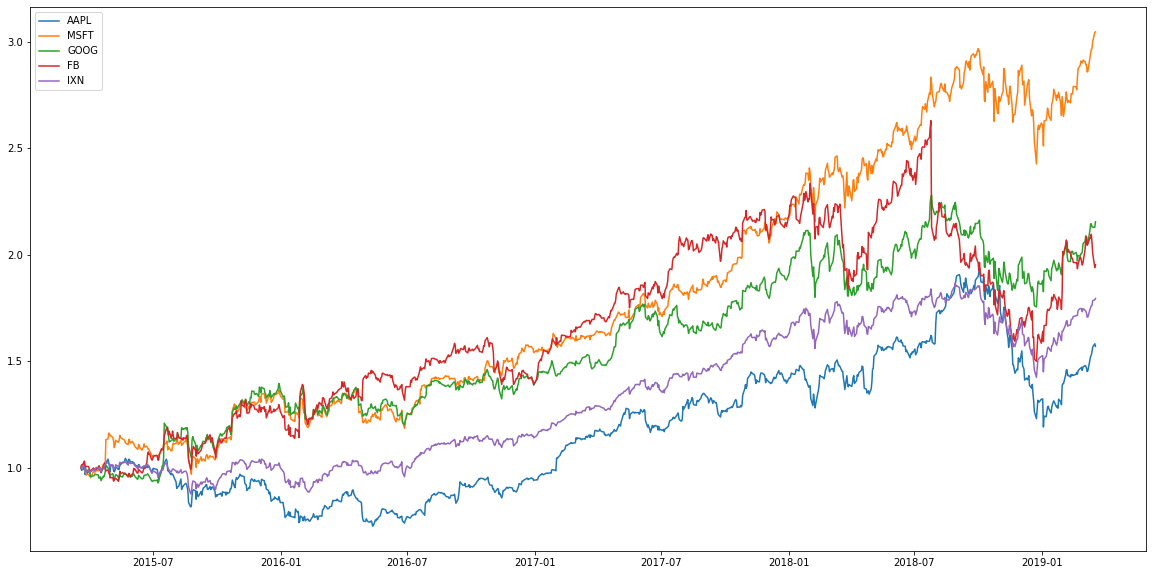

In [223]:
fig, ax = plt.subplots(figsize=(20,10))
for ticker in UNIVERSE:
    ax.plot( df[ticker]/df[ticker].iloc[0], label=ticker )
ax.legend()
plt.show()

## Pair Selection via Augemented Dickey-Fuller Test

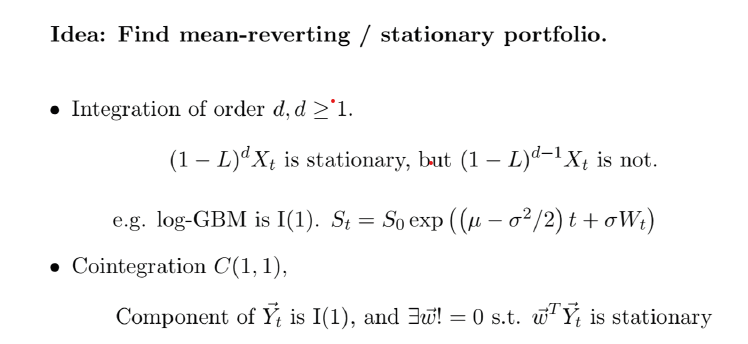

In [5]:
Image(filename='figure/1.png')

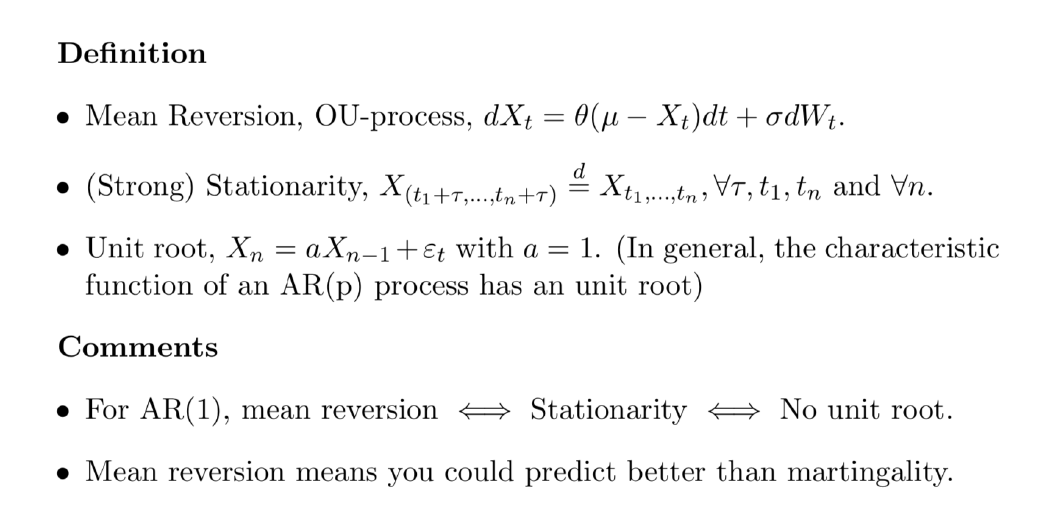

In [6]:
Image(filename='figure/2.png')

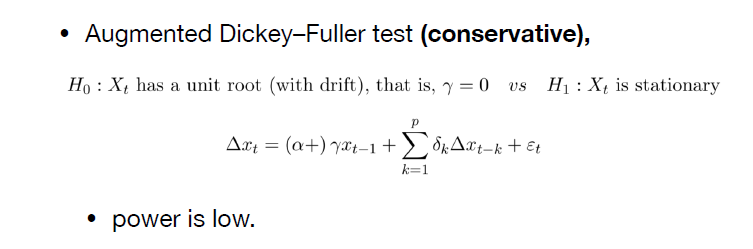

In [7]:
Image(filename='figure/3.png')

In [224]:
def getPair( df, critic=.05 ):
    opt_pair = []
    opt_pval = critic
    for i in range(len(UNIVERSE)):
        for j in range(i+1, len(UNIVERSE)):
            pval = coint( df[UNIVERSE[i]], df[UNIVERSE[j]] )[1]
            if pval < opt_pval:
                opt_pval = pval
                opt_pair = [UNIVERSE[i], UNIVERSE[j]]
            print( "pval of ADF test on {} and {} is {:.4f}".format(
                    UNIVERSE[i], UNIVERSE[j], pval) )
    return opt_pair, opt_pval

## Portfolio, Signal and Strategy Module

In [225]:
## Hard-code Parameters
TSRATE = 0.005 ## transaction rate 0.5%
LEVERAGE = 1. ## leverage of a margin account.
THRESH_FACTOR = 1. ## How many times of std would be used as threshold
BURNIN = 60 ## Training period and Burn-In period. BurnIn would be used to do pair-selection, model parameter tuning, threshold tuning, and so on.\

# model parameters
TRAIN = 60 ## linear regression
DELTA = 1e-3; GAMMA = 1e-3 ## kalman filter

In [226]:
## Portfolio and operations
class Portfolio( object ):
    def __init__( self, cash):
        self.position = np.zeros(2)
        self.cash = cash
        self.leverage = LEVERAGE
        self.buypow = self.cash * self.leverage
        self.status = 0
    
    def _calcQty( self, weight, priceVec ):
        return self.buypow / np.dot(np.abs(weight), priceVec)
    
    def _close( self, priceVec ):
        assert self.status in [-1, 1]
        self.cash += np.dot( self.position, priceVec ) 
        self.buypow = self.cash * self.leverage
        self.position = np.zeros(2)
        self.status = 0
    
    def _execute( self, weight, priceVec, direction ):
        qty = self._calcQty( weight, priceVec )
        self.position += qty * np.array(weight) * float(direction)
        tsCost = np.dot(np.abs(weight), priceVec) * qty * TSRATE
        self.cash -= np.dot(weight, priceVec) * qty * direction + tsCost
        self.buypow -= np.dot(np.abs(weight), priceVec) * qty
        self.status = direction
    
    def execute( self, signal ):
        if signal.direction == 0:
            self._close( signal.priceVec )
        else:
            self._execute( signal.weight, signal.priceVec, signal.direction )
            
    def getValue( self, priceVec ):
        return np.dot( self.position, priceVec ) + self.cash
        
        
## sanity check
pf1 = Portfolio( 10 )
pf1.getValue( [1, 2] )
pf1._calcQty( weight=[1, -1], priceVec=[2,2] )
pf1._execute( weight=[1, -1], priceVec=[2,2], direction=-1 )
print( "Cash {}, Position {}, BuyPower {}, Status {}".format( pf1.cash, pf1.position, pf1.buypow, pf1.status ) )
pf1._close( [1, 3] )
print( "Cash {}, Position {}, BuyPower {}, Status {}".format( pf1.cash, pf1.position, pf1.buypow, pf1.status ) )        

Cash 10.0, Position [-2.5  2.5], BuyPower 0.0, Status -1
Cash 15.0, Position [0. 0.], BuyPower 15.0, Status 0


In [227]:
## signal and signal sequence module.

class Signal( object ):

    def __init__( self, weight, direction, priceVec, time=None ):
        self.weight = weight
        self.direction = direction # 1 for long, -1 for short, 0 for close
        self.priceVec = priceVec
        self.time = time
        
class SignalSequence( object ):
    
    def __init__( self ):
        self.seq = {} # time -> list of signal
        self.status = 0 # 1 for long position, -1 for short position, 0 for no position
        
    def _addSignal( self, sig ):
        if sig.time in self.seq:
            self.seq[sig.time].append( sig )
        else:
            self.seq[sig.time] = [ sig ]
            
    def addSignal( self, weight, spread, threshold, priceVec, time ):
        
        if self.status * spread > 0:
            self._addSignal( Signal( weight, 0, priceVec, time) )
            self.status = 0
        
        if not self.status:
            if spread > threshold:
                self._addSignal( Signal( weight, -1, priceVec, time ) )
                self.status = -1
            elif spread < -threshold:
                self._addSignal( Signal( weight, 1, priceVec, time ) )
                self.status = 1
    
    def mapdirection( self, direction ):
        if direction == 0:
            return "close"
        if direction == 1:
            return "long"
        if direction == -1:
            return "short"
    
    def printSignal( self ):
        if not self.seq:
            print( "No trade is done." )
            return
        for time in sorted(self.seq.keys()):
            for sig in self.seq[time]:
                print( "At {}, {} portfolio ({:.4f}Stock1 + Stock2)".format(
                    sig.time, self.mapdirection(sig.direction), sig.weight[0], sig.weight[1]) )
            
seq = SignalSequence()
seq.addSignal( weight=[1,-1], spread=.5, threshold=.2, priceVec=[2,4], time="DAY-1")
seq.addSignal( weight=[.5,1.2], spread=-0.25, threshold=.2, priceVec=[2,2], time="DAY-2")
seq.addSignal( weight=[.5,1.2], spread=.1, threshold=.2, priceVec=[2.3,2], time="DAY-3")
seq.printSignal()

At DAY-1, short portfolio (1.0000Stock1 + Stock2)
At DAY-2, close portfolio (0.5000Stock1 + Stock2)
At DAY-2, long portfolio (0.5000Stock1 + Stock2)
At DAY-3, close portfolio (0.5000Stock1 + Stock2)


In [228]:
def summaryFromAccPNL( accPNL, factor = 252 ):
    '''accPNL should begin from 0. factor counts the number of trading days
    ref: https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns '''
    df = pd.Series( accPNL )
    dailyRet = df.pct_change()
    dailyVol    = np.std( dailyRet )

    TotRet = ( accPNL[-1] - accPNL[0] ) / accPNL[0]

    dailyRet.fillna(0.0, inplace=True)
    dailyRet.replace([np.inf, -np.inf, np.nan], 0.0, inplace=True)
    if (dailyRet.mean() == 0) and (dailyRet.std == 0):
        sharpe = 0
    else:
        sharpe = np.sqrt(factor) * dailyRet.mean() / dailyRet.std()
    return dailyVol, TotRet, sharpe

In [229]:
## trading strategy module
from sklearn.linear_model import LinearRegression
class PairTradingStratBase( object ):
    
    def __init__(self):
        self.sigseq = SignalSequence()
        self.portfolio = Portfolio( cash=10000 )
        self.model_params = { "train_samples":TRAIN }
        
    def model( self, burnInMode, ttidx=None, train_samples=None ):
        '''
        Input: df_tr(pd.DataFrame), price training dataframe (N1, 2)
               df_te(pd.DataFrame), price testing dataframe (N2, 2)
        Return: weight(list), weights for two securities (2,)
                df_spread(pd.Series), spread on df_te (N2,)
        This method could be overriden for other models. Default is the linear regression model.
        '''
        reg = LinearRegression()
        if burnInMode:
            reg.fit( self.price_df.iloc[:BURNIN, [0]], 
                     self.price_df.iloc[:BURNIN, 1] )
            df_spread = self.price_df.iloc[:BURNIN,1] - reg.predict( self.price_df.iloc[:BURNIN,[0]] )
            return _, df_spread
        reg.fit( self.price_df.iloc[(ttidx-TRAIN):ttidx, [0]],
                 self.price_df.iloc[(ttidx-TRAIN):ttidx, 1] )
        weight = [-reg.coef_[0], 1.]
        df_spread = self.price_df.iloc[[ttidx],1] - reg.predict( self.price_df.iloc[[ttidx],[0]] )

        return weight, df_spread
            
    
    def getSignal( self, df ): # df [N, M]
        
        ## pair-selection
        opt_pair, opt_pval = getPair( df.iloc[:BURNIN] )
        if opt_pair:
            print( "Select Pair {} and {} with p-val {:.4f}".format(opt_pair[0], opt_pair[1], opt_pval) )
            self.price_df = df[opt_pair]
        else:
            print( "No pair pass stationarity testing, use default pair {} and {}".format(UNIVERSE[0], UNIVERSE[1]) )
            self.price_df = df[[UNIVERSE[0], UNIVERSE[1]]]
        
        ## Run model on BurnIn period
        ## (x, y) y = w*x + b + \eps
        ## -> std(\eps), which would be used as threshold
        _, self.spread_df = self.model( burnInMode=True )
        threshold = THRESH_FACTOR * self.spread_df.std()
        
        ## Run model on testing period and archive signals
        ## [1-TRAIN]-> calculate spread on day 31, which gives us the signal
        ##          -> spread >(<) threshold: short(long) the portfolio if we don't have any positions
        ##          -> spread <(>) 0 clear position if we already short(long) the portfolio.
        ## [1-30][31], [2-31][32], ... 
        for idx, tt in enumerate( self.price_df.index[BURNIN: len(self.price_df)], BURNIN ):
            weight, spread = self.model( burnInMode=False, ttidx=idx, **self.model_params )
            self.sigseq.addSignal( weight, 
                                   spread[tt], 
                                   threshold, 
                                   self.price_df.loc[tt].to_list(), 
                                   tt.strftime("%Y-%m-%d") )
            self.spread_df[tt] = spread[tt] 
            threshold = THRESH_FACTOR * self.spread_df.iloc[-BURNIN:].std() 
        self.sigseq.printSignal()
        
    def runPortfolio( self ):
        self.accVal = pd.Series(dtype=float)
        for tt in self.price_df.index[BURNIN:]:
            if tt.strftime("%Y-%m-%d") in self.sigseq.seq.keys():
                for sig in self.sigseq.seq[tt.strftime("%Y-%m-%d")]:
                    self.portfolio.execute( sig )
            self.accVal[tt] = self.portfolio.getValue( self.price_df.loc[tt] )
        
        self.dailyVol, self.totRet, self.sharpe = summaryFromAccPNL( self.accVal )
        print( "DailyVol {:.4f}, totRet {:.4f}, sharpe {:.4f}".format(self.dailyVol, self.totRet, self.sharpe) )


In [230]:
stratobj = PairTradingStratBase()
stratobj.getSignal( df )
stratobj.runPortfolio()

pval of ADF test on AAPL and MSFT is 0.0405
pval of ADF test on AAPL and GOOG is 0.2418
pval of ADF test on AAPL and FB is 0.1264
pval of ADF test on AAPL and IXN is 0.0151
pval of ADF test on MSFT and GOOG is 0.7828
pval of ADF test on MSFT and FB is 0.1491
pval of ADF test on MSFT and IXN is 0.2642
pval of ADF test on GOOG and FB is 0.1090
pval of ADF test on GOOG and IXN is 0.1950
pval of ADF test on FB and IXN is 0.1466
Select Pair AAPL and IXN with p-val 0.0151
At 2015-06-22, short portfolio (-0.5546Stock1 + Stock2)
At 2015-06-26, close portfolio (-0.5358Stock1 + Stock2)
At 2015-06-29, long portfolio (-0.5248Stock1 + Stock2)
At 2015-07-09, close portfolio (-0.6330Stock1 + Stock2)
At 2015-07-15, long portfolio (-0.6409Stock1 + Stock2)
At 2015-07-22, close portfolio (-0.6190Stock1 + Stock2)
At 2015-07-22, short portfolio (-0.6190Stock1 + Stock2)
At 2015-08-20, close portfolio (-0.2685Stock1 + Stock2)
At 2015-08-20, long portfolio (-0.2685Stock1 + Stock2)
At 2015-09-17, close portfol

## Visualization

In [231]:
import datetime

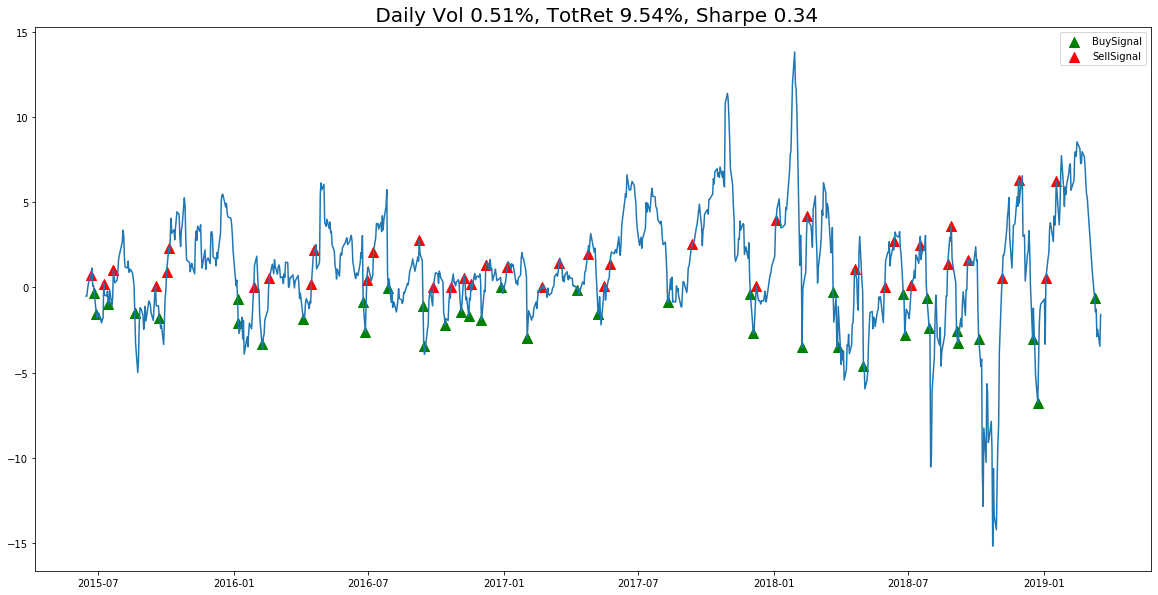

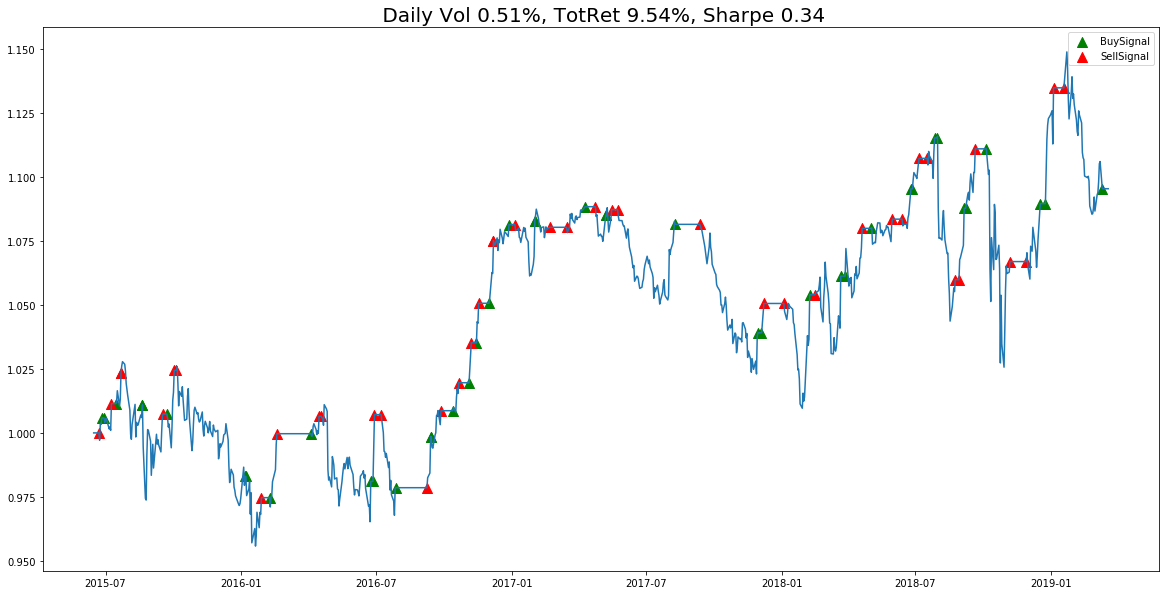

In [232]:
fig, ax = plt.subplots( figsize=(20, 10) )
ax.plot( stratobj.price_df.index[BURNIN:], stratobj.spread_df[BURNIN:] )
ax.set_title( " Daily Vol {:.2f}%, TotRet {:.2f}%, Sharpe {:.2f}".format(
               stratobj.dailyVol*100, stratobj.totRet*100, stratobj.sharpe ),
               fontsize=20 )
direction = []; timeline = []; spread = []; accVal = []
for tt, sigs in stratobj.sigseq.seq.items():
    for sig in sigs:
        timeline.append( datetime.datetime.strptime(tt, "%Y-%m-%d") )
        direction.append( sig.direction )
        spread.append( stratobj.spread_df[tt] )
        accVal.append( stratobj.accVal[tt] )
for idx, action in enumerate(direction):
    if action == 0:
        direction[idx] = - direction[idx-1]
        
ax.scatter(np.array(timeline)[np.array(direction) == 1],
           np.array(spread)[np.array(direction) == 1] ,
           c='g', marker="^", label="BuySignal", s=100)
ax.scatter(np.array(timeline)[np.array(direction) == -1],
           np.array(spread)[np.array(direction) == -1],
           c='r', marker="^", label="SellSignal", s=100)
ax.legend()

fig, ax = plt.subplots( figsize=(20, 10) )
ax.plot( stratobj.price_df.index[BURNIN:], stratobj.accVal/stratobj.accVal.iloc[0] )
ax.scatter(np.array(timeline)[np.array(direction) == 1],
           np.array(accVal/stratobj.accVal.iloc[0])[np.array(direction) == 1],
           c='g', marker="^", label="BuySignal", s=100)
ax.scatter(np.array(timeline)[np.array(direction) == -1],
           np.array(accVal/stratobj.accVal.iloc[0])[np.array(direction) == -1],
           c='r', marker="^", label="SellSignal", s=100)

ax.set_title( " Daily Vol {:.2f}%, TotRet {:.2f}%, Sharpe {:.2f}".format(
               stratobj.dailyVol*100, stratobj.totRet*100, stratobj.sharpe ),
               fontsize=20 )
ax.legend()
plt.show()

## Kalman Filter

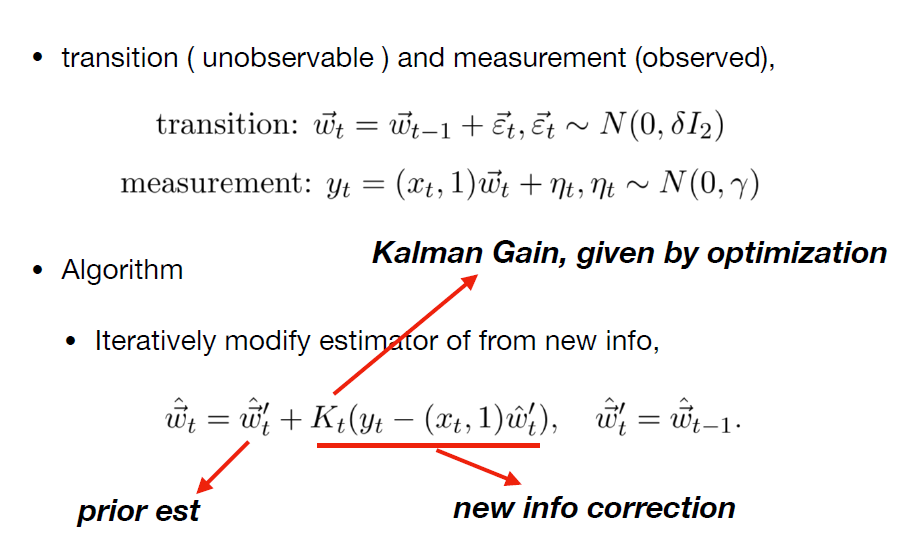

In [8]:
Image(filename='figure/4.png')

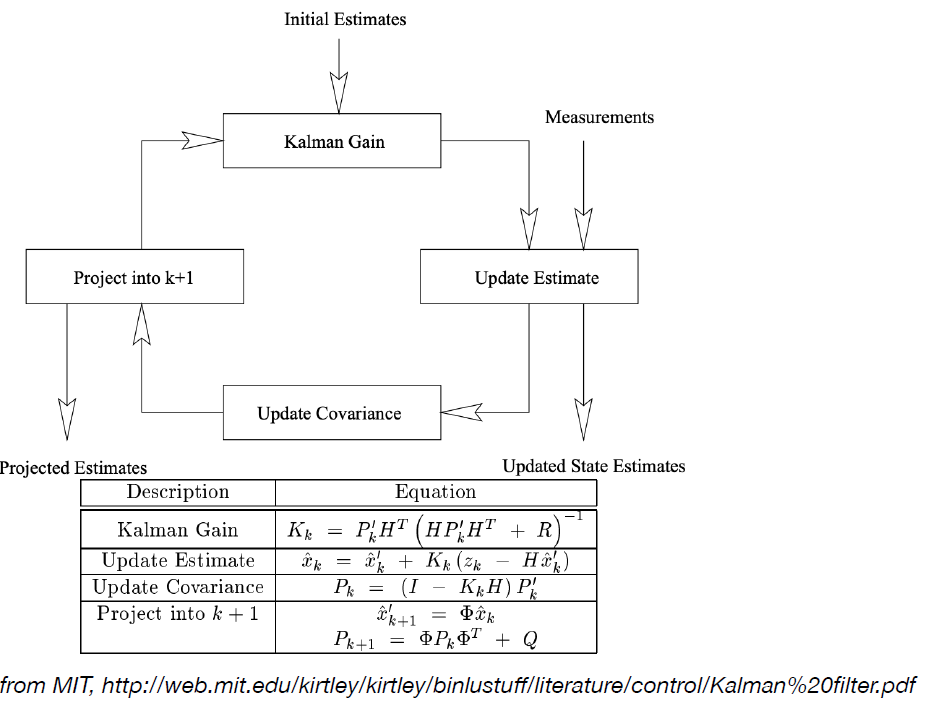

In [10]:
Image(filename='figure/5.png')

* Remark: Performance of Kalman Filter is heavily dependent on the choice of hyper-parameter. 

In [275]:
## trading strategy module
'''
Consider Kalman Filter,
\w_{k+1} = \w_k + _k, u_k\sim Normal(0, Q),
\y_k = x_k\w_k + v_k, v_k\sim Normal(0, R),
where
trainsition cov: Q = I2 * delta / (1 - delta),
observation variance: R = gamma.
'''
DELTA = 1e-5
DELTA2 = .1
GAMMA = 1.
THRESH_FACTOR = 1. 
BURNIN = 30

from pykalman import KalmanFilter
class KFStrat( PairTradingStratBase ):
    
    def __init__( self ):
        super(KFStrat, self).__init__()
        self.kf = None
        self.model_params = { "delta_1":DELTA,
                              "delta_2":DELTA2,
                              "gamma":GAMMA }
    
    def model( self, burnInMode=True, ttidx=None, delta_1=DELTA, delta_2=DELTA2, gamma=GAMMA ):
        ## override model method 
        covQ = np.array([delta_1/(1.-delta_1), delta_2/(1-delta_2)]) * np.eye(2)
        varR = gamma
        if burnInMode:
            ## build kf model from training data
            obsMat = np.vstack( (self.price_df.iloc[:BURNIN,0].to_numpy(),  
                                 np.ones(BURNIN)) ).T.reshape(-1,1,2)
            obsVec = self.price_df.iloc[:BURNIN,1].to_numpy().reshape(-1, 1)
            self.kf = KalmanFilter( n_dim_obs=1,
                                    n_dim_state=2,
                                    initial_state_mean=np.zeros(2),
                                    initial_state_covariance=np.ones((2, 2)),
                                    transition_matrices=np.eye(2),
                                    observation_matrices=obsMat,
                                    observation_covariance=varR,
                                    transition_covariance=covQ )
            
            w_kf, cov_kf = self.kf.filter( obsVec )
            assert len(w_kf) == BURNIN
            df_spread = self.price_df.iloc[:BURNIN,1] - w_kf[:,0]*self.price_df.iloc[:BURNIN,0] - w_kf[:,1]
            self.w_kf, self.cov_kf = w_kf[-1], cov_kf[-1] 
            return _, df_spread
        
        ## update kalman fiter and return weight
        assert self.kf is not None
        self.w_kf, self.cov_kf = self.kf.filter_update(
                        filtered_state_mean = self.w_kf,
                        filtered_state_covariance = self.cov_kf,
                        observation = self.price_df.iloc[ttidx, 1],
                        observation_matrix = np.array( [self.price_df.iloc[ttidx, 0], 1] ).reshape(1, 2) )
     
        weight = [-self.w_kf[0], 1.]
        df_spread = self.price_df.iloc[[ttidx],1] - self.w_kf[0]*self.price_df.iloc[[ttidx],0] - self.w_kf[1]

        return weight, df_spread


In [276]:
stratobj = KFStrat()
stratobj.getSignal( df )
stratobj.runPortfolio()

pval of ADF test on AAPL and MSFT is 0.2631
pval of ADF test on AAPL and GOOG is 0.4818
pval of ADF test on AAPL and FB is 0.3793
pval of ADF test on AAPL and IXN is 0.0523
pval of ADF test on MSFT and GOOG is 1.0000
pval of ADF test on MSFT and FB is 0.6279
pval of ADF test on MSFT and IXN is 0.9157
pval of ADF test on GOOG and FB is 0.6051
pval of ADF test on GOOG and IXN is 0.7182
pval of ADF test on FB and IXN is 0.6150
No pair pass stationarity testing, use default pair AAPL and MSFT
At 2015-05-22, long portfolio (-0.3394Stock1 + Stock2)
At 2015-05-27, close portfolio (-0.3393Stock1 + Stock2)
At 2015-06-18, short portfolio (-0.3404Stock1 + Stock2)
At 2015-06-22, close portfolio (-0.3406Stock1 + Stock2)
At 2015-06-24, long portfolio (-0.3390Stock1 + Stock2)
At 2015-07-08, close portfolio (-0.3361Stock1 + Stock2)
At 2015-07-08, short portfolio (-0.3361Stock1 + Stock2)
At 2015-07-15, close portfolio (-0.3380Stock1 + Stock2)
At 2015-07-20, long portfolio (-0.3361Stock1 + Stock2)
At 20

DailyVol 0.0057, totRet 0.3245, sharpe 0.8456


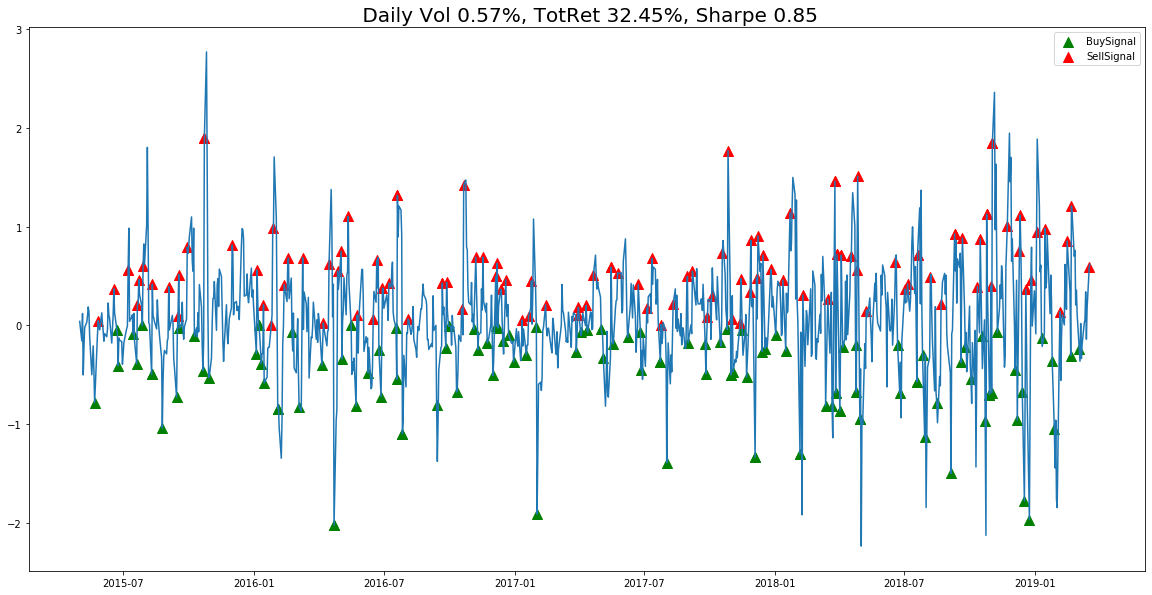

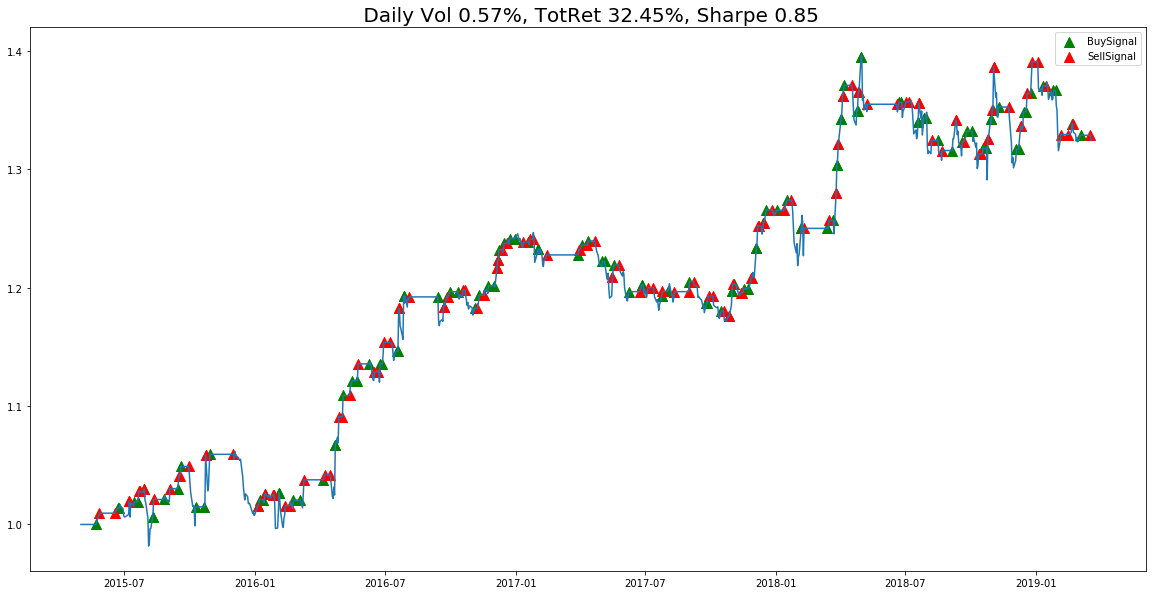

In [277]:
fig, ax = plt.subplots( figsize=(20, 10) )
ax.plot( stratobj.price_df.index[BURNIN:], stratobj.spread_df[BURNIN:] )
ax.set_title( " Daily Vol {:.2f}%, TotRet {:.2f}%, Sharpe {:.2f}".format(
               stratobj.dailyVol*100, stratobj.totRet*100, stratobj.sharpe ),
               fontsize=20 )
direction = []; timeline = []; spread = []; accVal = []
for tt, sigs in stratobj.sigseq.seq.items():
    for sig in sigs:
        timeline.append( datetime.datetime.strptime(tt, "%Y-%m-%d") )
        direction.append( sig.direction )
        spread.append( stratobj.spread_df[tt] )
        accVal.append( stratobj.accVal[tt] )
for idx, action in enumerate(direction):
    if action == 0:
        direction[idx] = - direction[idx-1]
        
ax.scatter(np.array(timeline)[np.array(direction) == 1],
           np.array(spread)[np.array(direction) == 1] ,
           c='g', marker="^", label="BuySignal", s=100)
ax.scatter(np.array(timeline)[np.array(direction) == -1],
           np.array(spread)[np.array(direction) == -1],
           c='r', marker="^", label="SellSignal", s=100)
ax.legend()

fig, ax = plt.subplots( figsize=(20, 10) )
ax.plot( stratobj.price_df.index[BURNIN:], stratobj.accVal/stratobj.accVal.iloc[0] )
ax.scatter(np.array(timeline)[np.array(direction) == 1],
           np.array(accVal/stratobj.accVal.iloc[0])[np.array(direction) == 1],
           c='g', marker="^", label="BuySignal", s=100)
ax.scatter(np.array(timeline)[np.array(direction) == -1],
           np.array(accVal/stratobj.accVal.iloc[0])[np.array(direction) == -1],
           c='r', marker="^", label="SellSignal", s=100)

ax.set_title( " Daily Vol {:.2f}%, TotRet {:.2f}%, Sharpe {:.2f}".format(
               stratobj.dailyVol*100, stratobj.totRet*100, stratobj.sharpe ),
               fontsize=20 )
ax.legend()
plt.show()